# #1 Emissions Datathon - Permian, Mean Pixel values and CNN

### Prepare Dataframe

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.pyplot import *
import imageio
from skimage.io import imread

from tqdm import tqdm

import cv2   #For image processing

import tensorflow as tf
#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model



from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of data
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv, rgba2rgb
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage import io, color

In [2]:
image_train = Path('C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Train2')

dir_name = r'C:\Users\vasan\OneDrive\EmissionsDatathon\Zeroing Methane Emissions - Dataset'
filename_suffix = 'csv'

In [3]:
filepaths = pd.Series(list(image_train.glob(r'**/*.png')), name='Filepath').astype(str)

In [4]:
filepaths.head()

0    C:\Users\vasan\OneDrive\EmissionsDatathon\Data...
1    C:\Users\vasan\OneDrive\EmissionsDatathon\Data...
2    C:\Users\vasan\OneDrive\EmissionsDatathon\Data...
3    C:\Users\vasan\OneDrive\EmissionsDatathon\Data...
4    C:\Users\vasan\OneDrive\EmissionsDatathon\Data...
Name: Filepath, dtype: object

In [5]:
df_filepaths = filepaths.to_frame()

In [6]:
res = os.listdir(image_train)
df_filepaths['Name'] = pd.DataFrame (res, columns = ['FileName'])

In [7]:
df_filepaths['candidate_id'] = [x.split('_')[-0] for x in df_filepaths['Name']]

In [8]:
df_filepaths.to_excel("all.xlsx")  

In [9]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_csv("plume_attribution_2019-2022 Jeremy Zhao.csv", thousands=',', skiprows = skiprows)
#df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,Unnamed: 0,source_id,candidate_id,plume_lat,plume_lon,date,source_type,ipcc,qplume,sigma_qplume,time_of_detection,plume_tif,rgb_tif
0,0,A0001,GAO20210712t153850p0000-A,40.586588,-104.82330,2021-07-12 00:00:00,landfill,6A Solid Waste Disposal On Land,198.690714,56.089373,NaN,NaN,NaN
1,1,A0002,GAO20210720t152559p0000-A,40.574605,-104.68813,2021-07-20 00:00:00,livestock,3A2 Manure Management,659.384534,215.976289,NaN,NaN,NaN
2,2,A0002,GAO20210712t153850p0000-B,40.574387,-104.68855,2021-07-12 00:00:00,livestock,3A2 Manure Management,458.494606,167.196121,NaN,NaN,NaN
3,3,A0002,GAO20210718t152410p0000-B,40.573827,-104.68812,2021-07-18 00:00:00,livestock,3A2 Manure Management,242.145473,140.004235,NaN,NaN,NaN
4,4,A0003,GAO20210712t153850p0000-C,40.572121,-104.68871,2021-07-12 00:00:00,livestock,3A2 Manure Management,425.330806,171.220361,NaN,NaN,NaN


In [10]:
df['candidate_id'].nunique()

7292

In [11]:
df.shape

(8752, 13)

In [12]:
dup = df[df['candidate_id'].duplicated() == True]

In [13]:
#dup.to_excel("dup.xlsx")  

In [14]:
#df.to_excel("df.xlsx")  

In [15]:
df = df.drop_duplicates(subset='candidate_id', keep="first")

In [16]:
print(df.shape)
print(df_filepaths.shape)

(7292, 13)
(3059, 3)


In [17]:
df2 = pd.merge(df, df_filepaths, on='candidate_id')

In [18]:
print(df2.shape)

(3058, 15)


In [19]:
df2.head()

,Unnamed: 0,source_id,candidate_id,plume_lat,plume_lon,date,source_type,ipcc,qplume,sigma_qplume,time_of_detection,plume_tif,rgb_tif,Filepath,Name
0,0,A0001,GAO20210712t153850p0000-A,40.586588,-104.82330,2021-07-12 00:00:00,landfill,6A Solid Waste Disposal On Land,198.690714,56.089373,NaN,NaN,NaN,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,GAO20210712t153850p0000-A_r174_c3465-plume.png
1,1,A0002,GAO20210720t152559p0000-A,40.574605,-104.68813,2021-07-20 00:00:00,livestock,3A2 Manure Management,659.384534,215.976289,NaN,NaN,NaN,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,GAO20210720t152559p0000-A_r380_c5956-plume.png
2,2,A0002,GAO20210712t153850p0000-B,40.574387,-104.68855,2021-07-12 00:00:00,livestock,3A2 Manure Management,458.494606,167.196121,NaN,NaN,NaN,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,GAO20210712t153850p0000-B_r468_c6000-plume.png
3,3,A0002,GAO20210718t152410p0000-B,40.573827,-104.68812,2021-07-18 00:00:00,livestock,3A2 Manure Management,242.145473,140.004235,NaN,NaN,NaN,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,GAO20210718t152410p0000-B_r406_c6016-plume.png
4,4,A0003,GAO20210712t153850p0000-C,40.572121,-104.68871,2021-07-12 00:00:00,livestock,3A2 Manure Management,425.330806,171.220361,NaN,NaN,NaN,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,GAO20210712t153850p0000-C_r524_c5997-plume.png


In [20]:
df2['candidate_id'].nunique()

3058

In [21]:
df2=df2.dropna(subset=["qplume"])

In [22]:
df2.shape

(3056, 15)

In [23]:
print("Upper limit",df2['qplume'].mean() + 3*df2['qplume'].std())
print("Lower limit",df2['qplume'].mean() - 3*df2['qplume'].std())

Upper limit 2805.5444311201527
Lower limit -1772.573140739497


In [24]:
df2 = df2[(df2['qplume'] < 2805.5444311201527)]
df2.shape

(2980, 15)

In [25]:
df2.to_excel("allfinal.xlsx")  

### Image Processing

In [26]:
#def image_processing(fil):
#Open image and import it as a numpy array
#    image2 = imread(fil)
    
#    feature_matrix = np.zeros((217,217))
    
#    for i in range(0,image2.shape[0]):
#        for j in range(0,image2.shape[1]):
#            feature_matrix[i][j] = ((int(image2[i,j,0]) + int(image2[i,j,1]) + int(image2[i,j,2]))/3)
        
#    features = np.reshape(feature_matrix, (217*217))
    
#    return features

In [27]:
def image_processing(fil):
#Open image and import it as a numpy array
    im2 = imread(fil)
    im2_rgb = color.rgba2rgb(im2)
    im2_hsv = rgb2hsv(im2_rgb)
    
    mask = im2_hsv[:,:,1] > 0.4
    
    red = im2[:,:,0]*mask
    green = im2[:,:,1]*mask
    blue = im2[:,:,2]*mask
    mask2 = np.dstack((red,green,blue))
    
    mask3 = rgb2gray(mask2)
    
#    features = mask3.flatten()
    
#    feature_matrix = np.zeros((217,217))
    
#    for i in range(0,mask2.shape[0]):
#        for j in range(0,mask2.shape[1]):
#            feature_matrix[i][j] = ((int(mask2[i,j,0]) + int(mask2[i,j,1]) + int(mask2[i,j,2]))/3)
        
    mask3 = cv2.resize(mask3, (217, 217))
    features = np.reshape(mask3, (217*217))
    
    return features

In [28]:
#Test Function
#fil = "C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Train/ang20190922t192642_ang20190922t192642-2_r4578_c217-plume.png"
#image_processing(fil)

In [29]:
image_list = []

In [30]:
for file in tqdm(df2['Filepath'].tolist()[:]):
    image_list.append(image_processing(file))

100%|██████████| 2980/2980 [00:56<00:00, 52.72it/s]


In [32]:
X = np.array(image_list)

In [33]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
np.save('processed_217x217_image.npy',X/255,allow_pickle=True)

### Preparing dataset for Model

In [35]:
Y = np.array(df2.qplume.tolist())

In [40]:
Y

array([198.690714  , 659.384534  , 458.494606  , ...,  58.74497328,
       262.239608  ,  78.31375757])

In [41]:
mean = np.mean(Y)
mean

426.75688922404026

In [42]:
print(X.shape)
print(Y.shape)

(2980, 47089)
(2980,)


In [43]:
# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [44]:
img_rows, img_cols = 217, 217
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_val.shape

(596, 217, 217, 1)

In [45]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

In [46]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(1788, 217, 217, 1)
(1788,)
(596, 217, 217, 1)
(596,)
(596, 217, 217, 1)
(596,)


### Model

In [47]:
#Define a Convolutional Neural Network Model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
#model.add(Dense(n_classes, activation='softmax'))
model.add(Dense(1, activation='relu'))
learning_rate = 0.001

model.compile(loss = 'mse',
              optimizer = Adam(learning_rate))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 215, 215, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 215, 215, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 213, 213, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 213, 213, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 106, 106, 16)     0         
 )                                                               
                                                        

In [48]:
save_at = "model_regression2.hdf5"
save_best2 = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

In [49]:
np.isnan(X).any()

False

In [50]:
np.isnan(Y).any()

False

In [51]:
#Train the CNN

history = model.fit( X_train, Y_train, 
                    epochs = 15, batch_size = 100, 
                    callbacks=[save_best2], verbose=1, 
                   validation_data = (X_val, Y_val))

Epoch 1/15
18/18 [==============================] - 98s 5s/step - loss: 206591.6406 - val_loss: 375352.6562
Epoch 2/15
18/18 [==============================] - 106s 6s/step - loss: 119894.2109 - val_loss: 358795.7500
Epoch 3/15
18/18 [==============================] - 109s 6s/step - loss: 97543.4297 - val_loss: 358245.0625
Epoch 4/15
18/18 [==============================] - 105s 6s/step - loss: 79257.9297 - val_loss: 371441.2500
Epoch 5/15
18/18 [==============================] - 102s 6s/step - loss: 77167.5078 - val_loss: 345340.7812
Epoch 6/15
18/18 [==============================] - 104s 6s/step - loss: 51404.5586 - val_loss: 343044.1250
Epoch 7/15
18/18 [==============================] - 105s 6s/step - loss: 45769.2734 - val_loss: 345545.3438
Epoch 8/15
18/18 [==============================] - 107s 6s/step - loss: 31989.0645 - val_loss: 330866.0938
Epoch 9/15
18/18 [==============================] - 110s 6s/step - loss: 27358.7324 - val_loss: 305970.8750
Epoch 10/15
18/18 [========

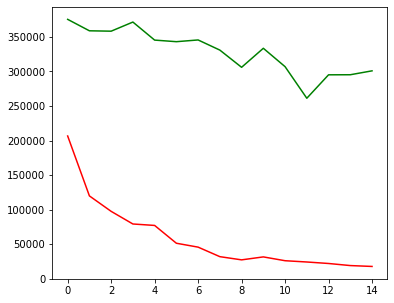

In [52]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='g')
plt.show()

### Predication

In [53]:
Y_pred = np.round(model.predict(X_test))

19/19 [==============================] - 6s 288ms/step


In [54]:
# Calculate the mean squared error
mse = mean_squared_error(Y_test, Y_pred)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

r2 = r2_score(Y_test, Y_pred)
print("Test R^2 Score: {:.5f}".format(r2))

Root Mean Squared Error: 607.098262057299
Test R^2 Score: -0.34206


### Submission

In [55]:
image_sub = []

In [56]:
image_test = Path('C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Test')

In [57]:
testpaths = pd.Series(list(image_test.glob(r'**/*.png')), name='Testpath').astype(str)

In [58]:
df_testpaths = testpaths.to_frame()

In [59]:
res = os.listdir(image_test)
df_testpaths['Name'] = pd.DataFrame (res, columns = ['TestName'])

In [60]:
df_testpaths

,Testpath,Name
0,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,01A.png
1,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,02A.png
2,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,03A.png
3,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,04A.png
4,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,05A.png
5,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,06A.png
6,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,07A.png
7,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,08A.png
8,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,09A.png
9,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,10A.png


In [61]:
for file in tqdm(df_testpaths['Testpath'].tolist()[:]):
    image_sub.append(image_processing(file))

100%|██████████| 20/20 [00:00<00:00, 97.17it/s] 


In [62]:
X_sub = np.array(image_sub)

In [63]:
np.save('sub_image.npy',X_sub/255,allow_pickle=True)

In [64]:
X_test.shape

(596, 217, 217, 1)

In [65]:
X_sub.shape

(20, 47089)

In [66]:
X_sub = X_sub.reshape(X_sub.shape[0], img_rows, img_cols, 1)
X_sub = X_sub.reshape(X_sub.shape[0], img_rows, img_cols, 1)
X_sub

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [67]:
Y_sub = np.round(model.predict(X_sub))

1/1 [==============================] - 0s 156ms/step


In [68]:
Y_sub

array([[148.],
       [103.],
       [119.],
       [125.],
       [109.],
       [ 88.],
       [113.],
       [ 92.],
       [ 85.],
       [140.],
       [107.],
       [134.],
       [137.],
       [131.],
       [133.],
       [115.],
       [118.],
       [ 93.],
       [130.],
       [122.]], dtype=float32)

In [70]:
np.savetxt('05_Others_HSV_SatFilter_CNN_Outliers2_Gray.csv', Y_sub, delimiter=',')